# Section 5.3 — Bayesian linear models

This notebook contains the code examples from [Section 5.3 Bayesian linear models]() from the **No Bullshit Guide to Statistics**.

See also examples in:
- [BambiRegression.ipynb](./explorations/BambiRegression.ipynb).
- [chp_03.ipynb](./explorations/PyBayesianBookCode/notebooks_updated/chp_03.ipynb)
- [ESCS_multiple_regression.ipynb](./explorations/bambi/ESCS_multiple_regression.ipynb)
- [bayesian regression in numpyro](https://nbviewer.org/github/pyro-ppl/numpyro/blob/master/notebooks/source/bayesian_regression.ipynb)
- Bambi demos: [01_multiple_linear_regression.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/01_multiple_linear_regression.ipynb)
  and [02_logistic_regression.ipynb](http://localhost:8888/lab/tree/notebooks/explorations/bambi-paper-main/original/02_logistic_regression.ipynb)
- [econmt_bayes_bambi.ipynb](./explorations/econmt_bayes_bambi.ipynb)

#### Notebook setup

In [1]:
# Ensure required Python modules are installed
%pip install --quiet numpy scipy seaborn statsmodels bambi==0.15.0 pymc==5.23.0 ministats

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load Python modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc={"font.family": "serif",
        "font.serif": ["Palatino", "DejaVu Serif", "serif"],
        "figure.figsize": (9,5)},
)
%config InlineBackend.figure_format = "retina"

<Figure size 640x480 with 0 Axes>

In [4]:
# Simple float __repr__  
if int(np.__version__.split(".")[0]) >= 2:
    np.set_printoptions(legacy='1.25')

# Set random seed for repeatability
np.random.seed(42)

In [5]:
# Download datasets/ directory if necessary
from ministats import ensure_datasets
ensure_datasets()

datasets/ directory present and ready.


In [6]:
# silence statsmodels kurtosistest warning when using n < 20
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
# silence ERROR messages when showing model graphs
# cf. https://github.com/pymc-devs/pymc/issues/7901
import logging
logging.getLogger("pytensor.graph.rewriting.basic").setLevel(logging.CRITICAL)

## Bayesian model

TODO: formula

TODO: graphical model diagram


## Example 1: students score as a function of effort

### Students dataset

In [8]:
students = pd.read_csv("datasets/students.csv")
students.shape

(15, 5)

In [9]:
students.head(3)

,student_ID,background,curriculum,effort,score
0,1,arts,debate,10.96,75.0
1,2,science,lecture,8.69,75.0
2,3,arts,debate,8.60,67.0


In [10]:
students[["effort","score"]].describe().T

,count,mean,std,min,25%,50%,75%,max
effort,15.0,8.904667,1.948156,5.21,7.76,8.69,10.35,12.0
score,15.0,72.580000,9.979279,57.00,68.00,72.70,75.75,96.2


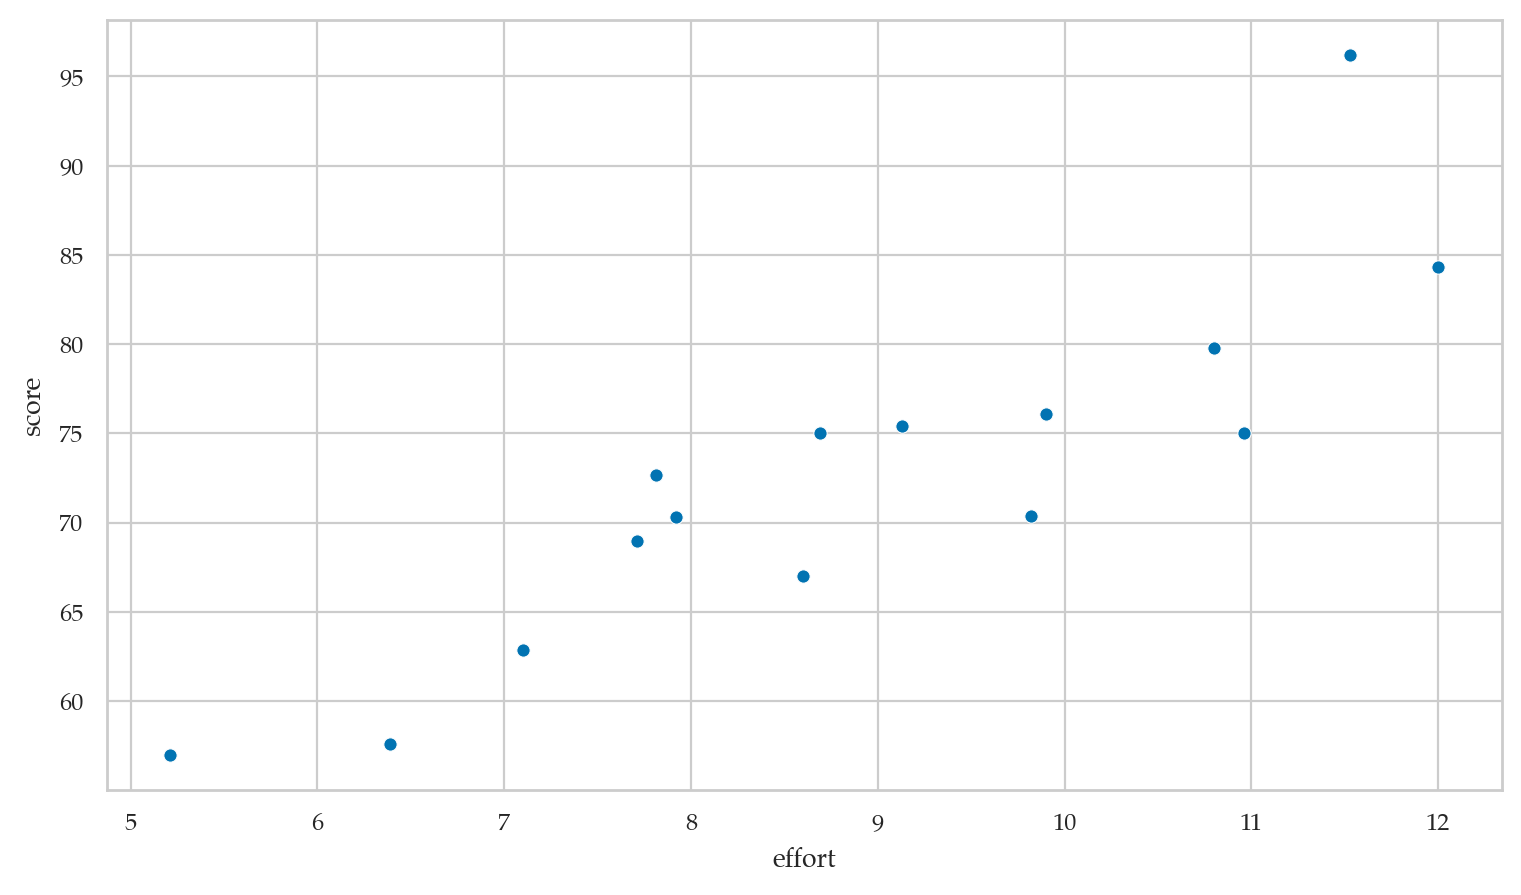

In [11]:
sns.scatterplot(x="effort", y="score", data=students);

### Bayesian model
TODO: add formulas

### Bambi model

In [12]:
import bambi as bmb

priors1 = {
    "Intercept": bmb.Prior("Normal", mu=70, sigma=20),
    "effort": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=10),
}

mod1 = bmb.Model("score ~ 1 + effort",
                 family="gaussian",
                 link="identity",
                 priors=priors1,
                 data=students)

### Inspecting the Bambi model

In [13]:
mod1

       Formula: score ~ 1 + effort
        Family: gaussian
          Link: mu = identity
  Observations: 15
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 70.0, sigma: 20.0)
            effort ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 10.0)

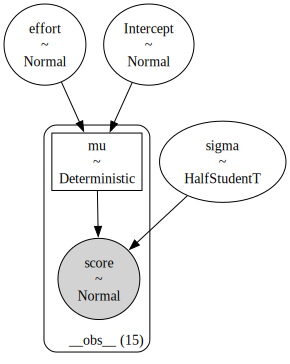

In [14]:
mod1.build()
mod1.graph()

### Prior predictive checks

In [15]:
# TODO

### Model fitting and analysis

In [16]:
idata1 = mod1.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, effort]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [17]:
import arviz as az
az.summary(idata1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
sigma,5.356,1.167,3.501,7.617
Intercept,32.549,6.962,18.903,45.336
effort,4.489,0.765,3.102,5.992


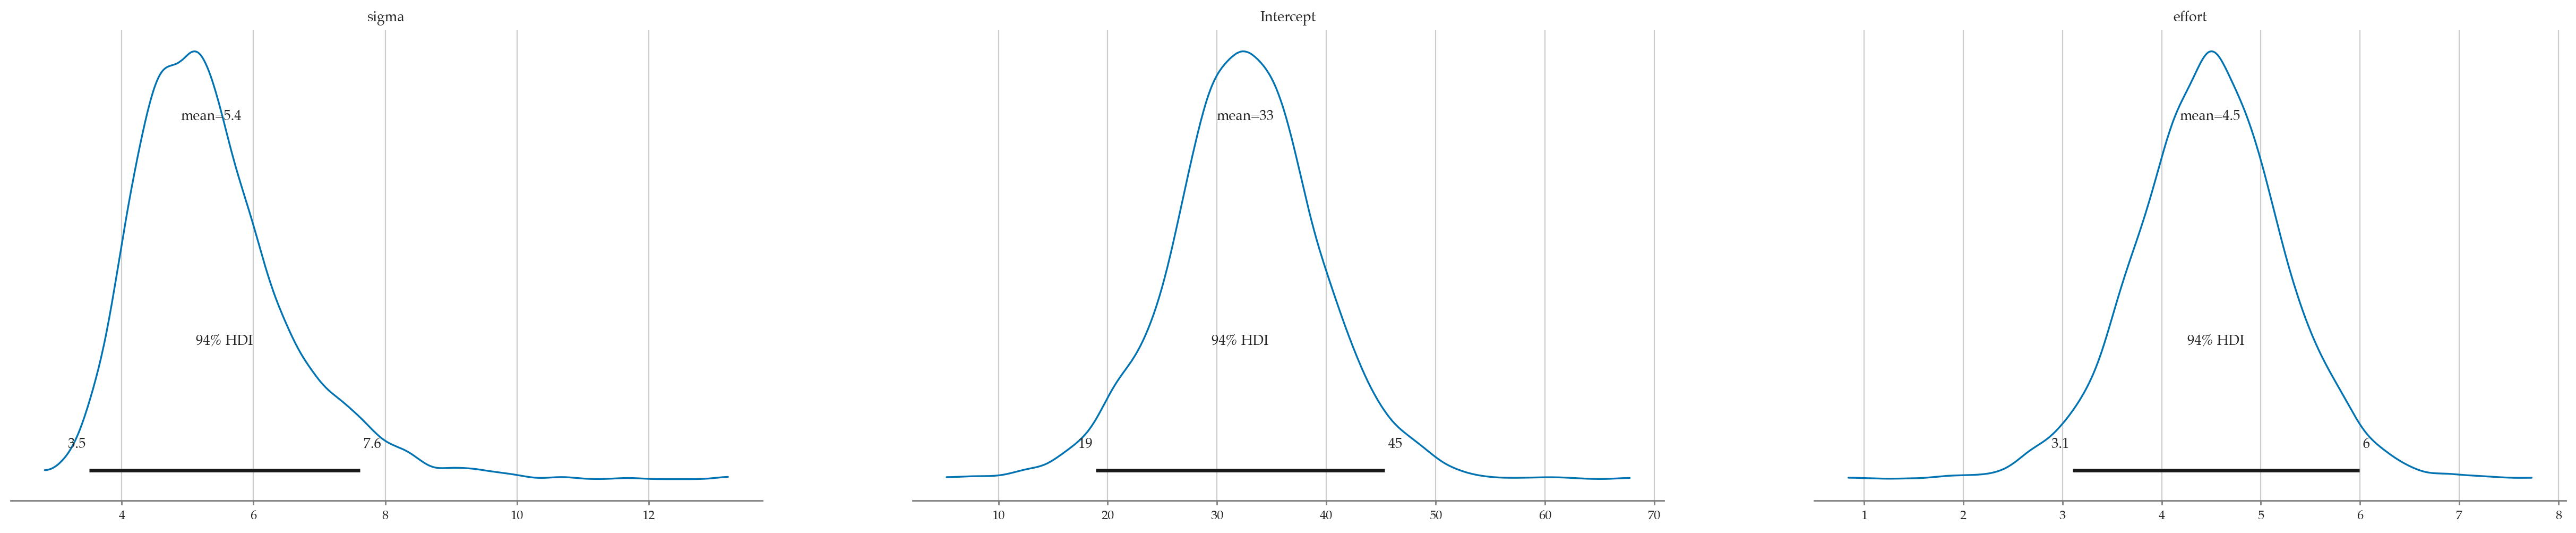

In [18]:
az.plot_posterior(idata1);

### Model predictions

Generate samples form the posterior predictive distribution,
then use the ArviZ function `plot_lm` to generate a complete visualization.

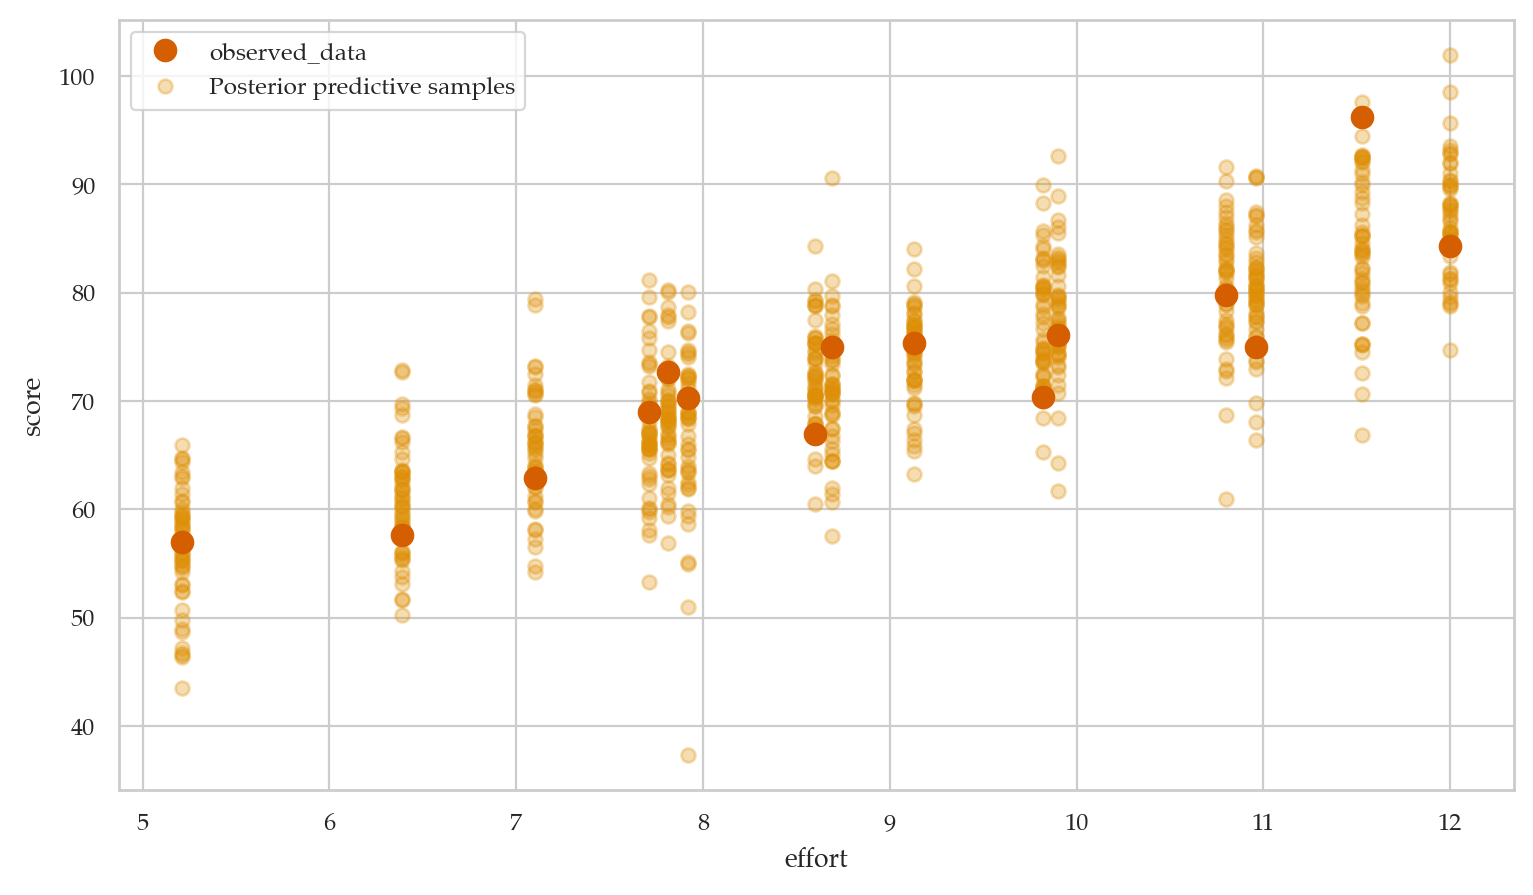

In [19]:
preds1 = mod1.predict(idata=idata1, data=students,
                      kind="response", inplace=False)
efforts = students["effort"]
az.plot_lm(y="score", idata=preds1, x=efforts,
           y_model="mu", y_hat="score",
           kind_pp="samples", kind_model="lines");

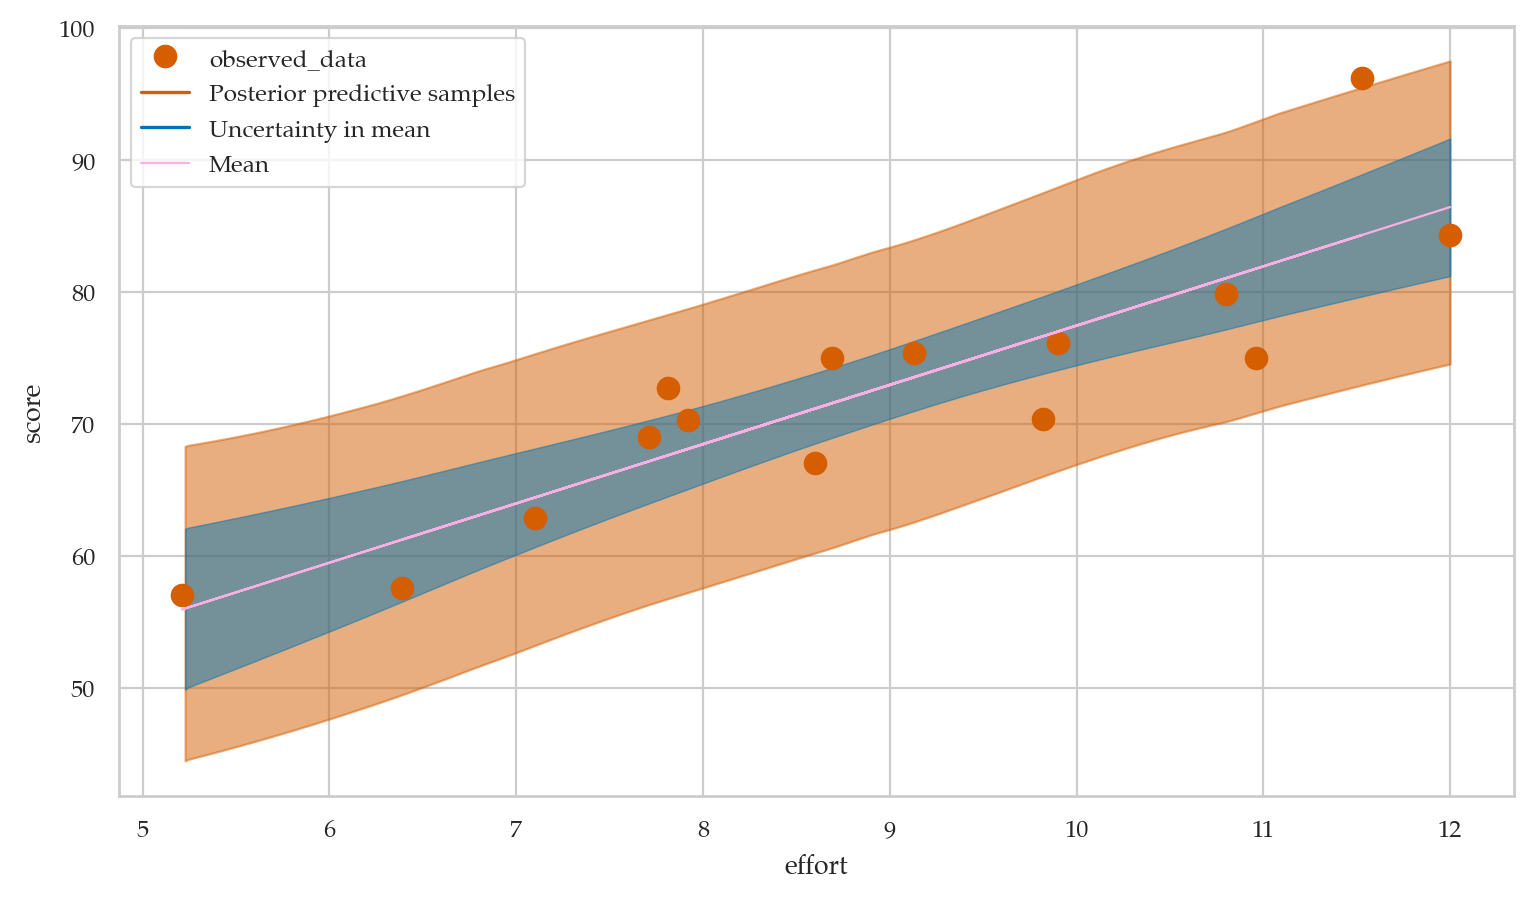

In [20]:
az.plot_lm(y="score", idata=preds1, x=efforts,
           y_model="mu", y_hat="score",
           kind_pp="hdi", kind_model="hdi");

### Comparing to frequentist results

For your convenience,
I'll reproduce the `statsmodels` analysis from Section 4.1.

In [21]:
# compare with statsmodels results
import statsmodels.formula.api as smf
lm1 = smf.ols("score ~ 1 + effort", data=students).fit()
lm1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,32.4658,6.155,5.275,0.000,19.169,45.763
effort,4.5049,0.676,6.661,0.000,3.044,5.966


In [22]:
np.sqrt(lm1.scale)

4.929598282660258

In [23]:
lm1.conf_int(alpha=0.06)  # to match 94% coverage of the Bayesian HDIs

,0,1
Intercept,19.786169,45.145449
effort,3.111697,5.898004


### Conclusions

We see effort tends to increase student scores.
The results we obtain from the Bayesian analysis are largely consistent with the frequentist results from Section 4.1,
however Bayesian models allow for simpler interpretation.

## Example 2: doctors sleep scores

### Doctors dataset

In [24]:
doctors = pd.read_csv("datasets/doctors.csv")
doctors.shape

(156, 9)

In [25]:
doctors.head(3)

,permit,loc,work,hours,caf,alc,weed,exrc,score
0,93273,rur,hos,21,2,0,5.0,0.0,63
1,90852,urb,cli,74,26,20,0.0,4.5,16
2,92744,urb,hos,63,25,1,0.0,7.0,58


In [26]:
doctors[["alc","weed","exrc","score"]].describe().T

,count,mean,std,min,25%,50%,75%,max
alc,156.0,11.839744,9.428506,0.0,3.750,11.0,19.0,44.0
weed,156.0,0.628205,1.391068,0.0,0.000,0.0,0.5,10.5
exrc,156.0,5.387821,4.796361,0.0,0.875,4.5,8.0,19.0
score,156.0,48.025641,20.446294,4.0,33.000,49.5,62.0,97.0


### Bayesian model
TODO: add formulas

### Bambi model

In [27]:
priors2 = {
    "Intercept": bmb.Prior("Normal", mu=50, sigma=40),
    # we'll set the priors for the slopes below
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=20),
}

mod2 = bmb.Model("score ~ 1 + alc + weed + exrc",
                 family="gaussian",
                 link="identity",
                 priors=priors2,
                 data=doctors)

# set the same prior for all slopes using `set_priors`
slope_prior = bmb.Prior("Normal", mu=0, sigma=10)
mod2.set_priors(common=slope_prior)

mod2

       Formula: score ~ 1 + alc + weed + exrc
        Family: gaussian
          Link: mu = identity
  Observations: 156
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 50.0, sigma: 40.0)
            alc ~ Normal(mu: 0.0, sigma: 10.0)
            weed ~ Normal(mu: 0.0, sigma: 10.0)
            exrc ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.0)

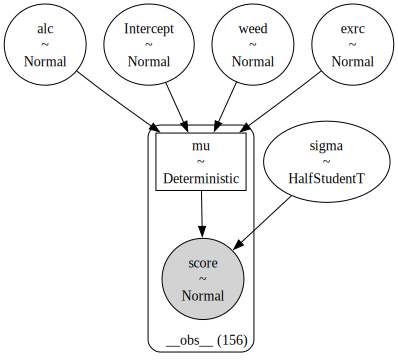

In [28]:
mod2.build()
mod2.graph()

### Prior predictive checks

What kind of parameters (lines) do we get from the data model
when the distribution of the parameters comes from random samples from the priors?

In [29]:
# TODO

### Model fitting and analysis

In [30]:
idata2 = mod2.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, alc, weed, exrc]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [31]:
az.summary(idata2, kind="stats", hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%
sigma,8.261,0.479,7.376,9.194
Intercept,60.445,1.293,57.867,62.873
alc,-1.799,0.071,-1.944,-1.663
weed,-1.020,0.481,-1.941,-0.075
exrc,1.768,0.138,1.485,2.028


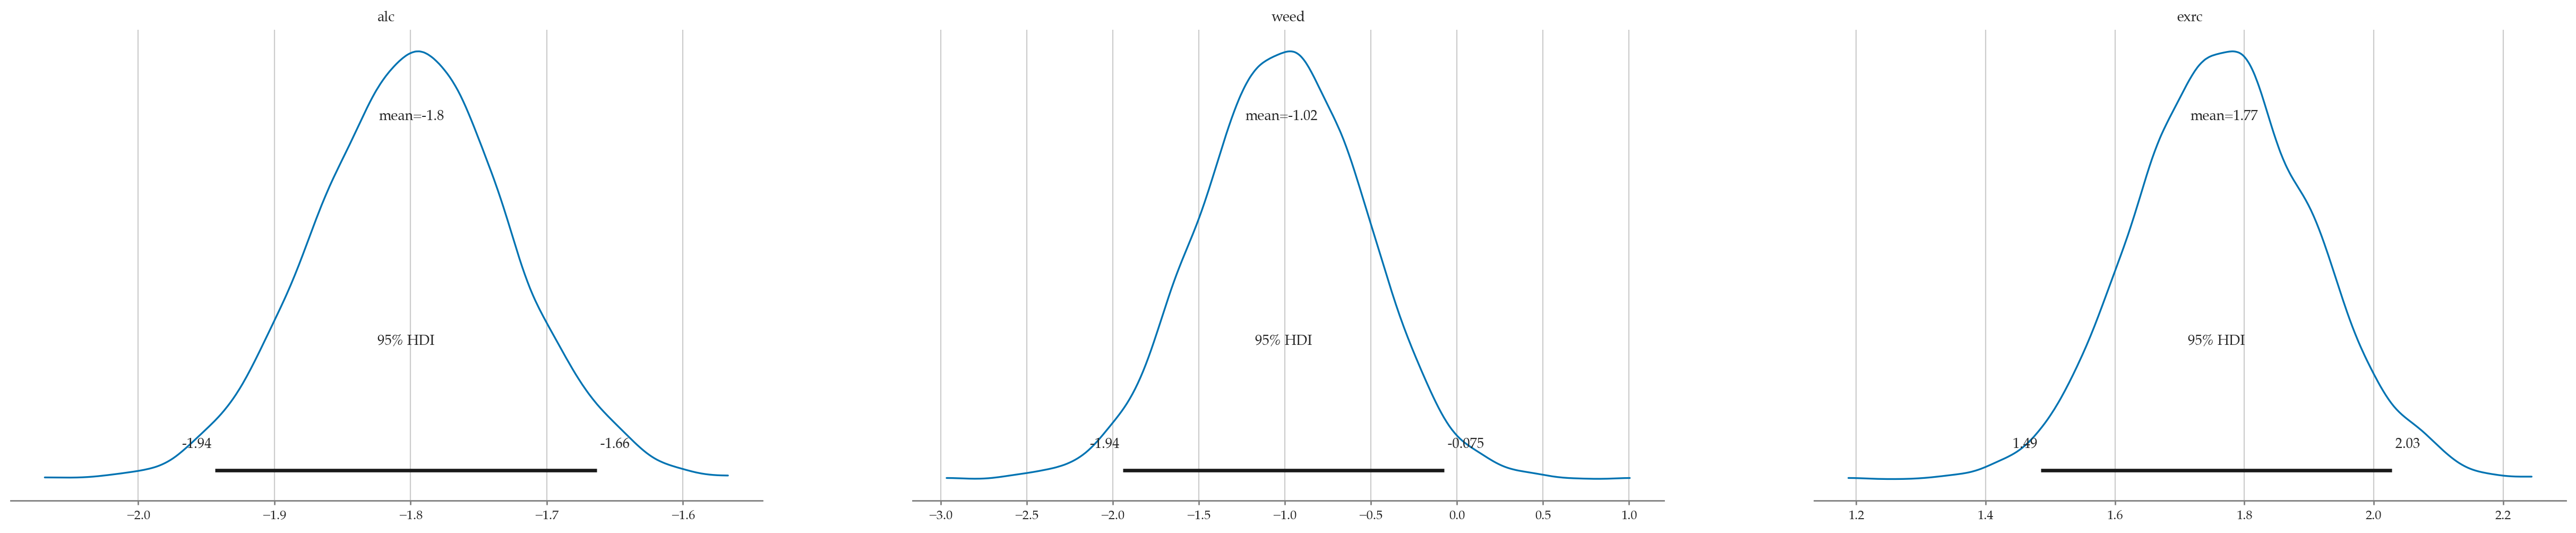

In [32]:
az.plot_posterior(idata2, hdi_prob=0.95, round_to=3,
                  var_names=["alc", "weed", "exrc"]);

### Partial correlation scale?

cf. https://bambinos.github.io/bambi/notebooks/ESCS_multiple_regression.html#summarize-effects-on-partial-correlation-scale

### Comparing to frequentist results

For your convenience,
I'll reproduce the `statsmodels` analysis from Section 4.2.

In [33]:
# compare with statsmodels results
import statsmodels.formula.api as smf
formula = "score ~ 1 + alc + weed + exrc"
lm2 = smf.ols(formula, data=doctors).fit()
lm2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,60.4529,1.289,46.885,0.000,57.905,63.000
alc,-1.8001,0.070,-25.726,0.000,-1.938,-1.662
weed,-1.0216,0.476,-2.145,0.034,-1.962,-0.081
exrc,1.7683,0.138,12.809,0.000,1.496,2.041


In [34]:
np.sqrt(lm2.scale)

8.20276811982562

### Conclusions

## Example 3: Bayesian logistic regression


### Interns data

In [35]:
interns = pd.read_csv("datasets/interns.csv")
interns.head(3)

,work,hired
0,42.5,1
1,39.3,0
2,43.2,1


### Bayesian logistic regression model

### Bambi model

In [36]:
priors3 = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=20),
    "work": bmb.Prior("Normal", mu=2, sigma=2),
}

mod3 = bmb.Model("hired ~ 1 + work",
                 family="bernoulli",
                 link="logit",
                 priors=priors3,
                 data=interns)
mod3

       Formula: hired ~ 1 + work
        Family: bernoulli
          Link: p = logit
  Observations: 100
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 20.0)
            work ~ Normal(mu: 2.0, sigma: 2.0)

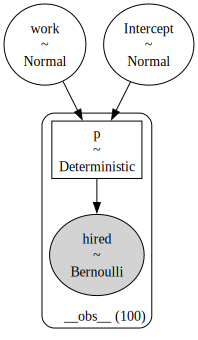

In [37]:
mod3.build()
mod3.graph()

### Prior predictive checks

In [38]:
# # TODO: improve prior predictive plot (currently runs too slowly)
# idatapp = mod3.prior_predictive()
# for i in range(300):
#     ps = idatapp["prior"].sel(draw=[i], chain=[0])["p"].values.flatten()
#     ws = interns["work"]
#     sps = ps[ws.sort_values().index]
#     sws = ws.sort_values().values
#     sns.lineplot(x=sws, y=sps, alpha=0.2)

### Model fitting and analysis

In [39]:
idata3 = mod3.fit(random_seed=42)

Modeling the probability that hired==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, work]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [40]:
az.summary(idata3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,-88.665,21.477,-129.468,-52.000
work,2.233,0.542,1.310,3.268


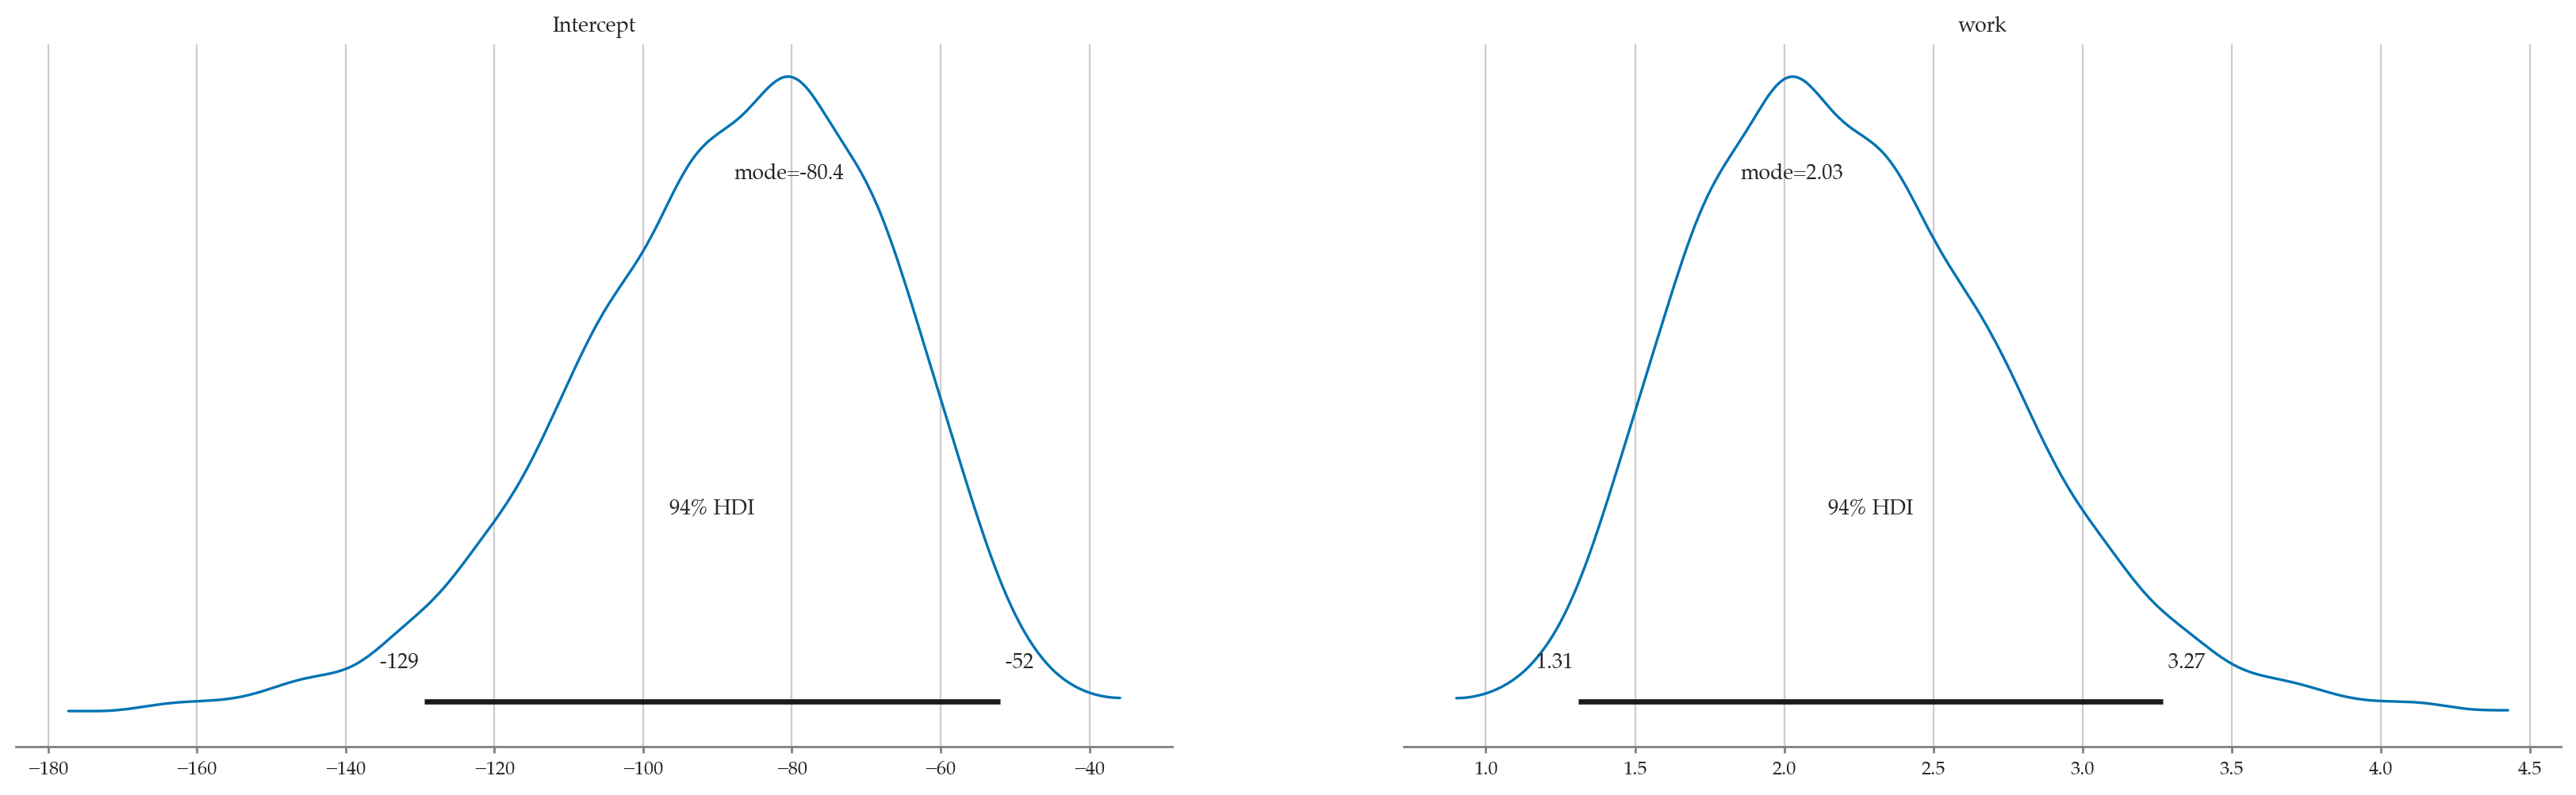

In [41]:
az.plot_posterior(idata3, round_to=3, point_estimate="mode");

#### Visualize variability of the results

MAP estimates: -80.4 2.03


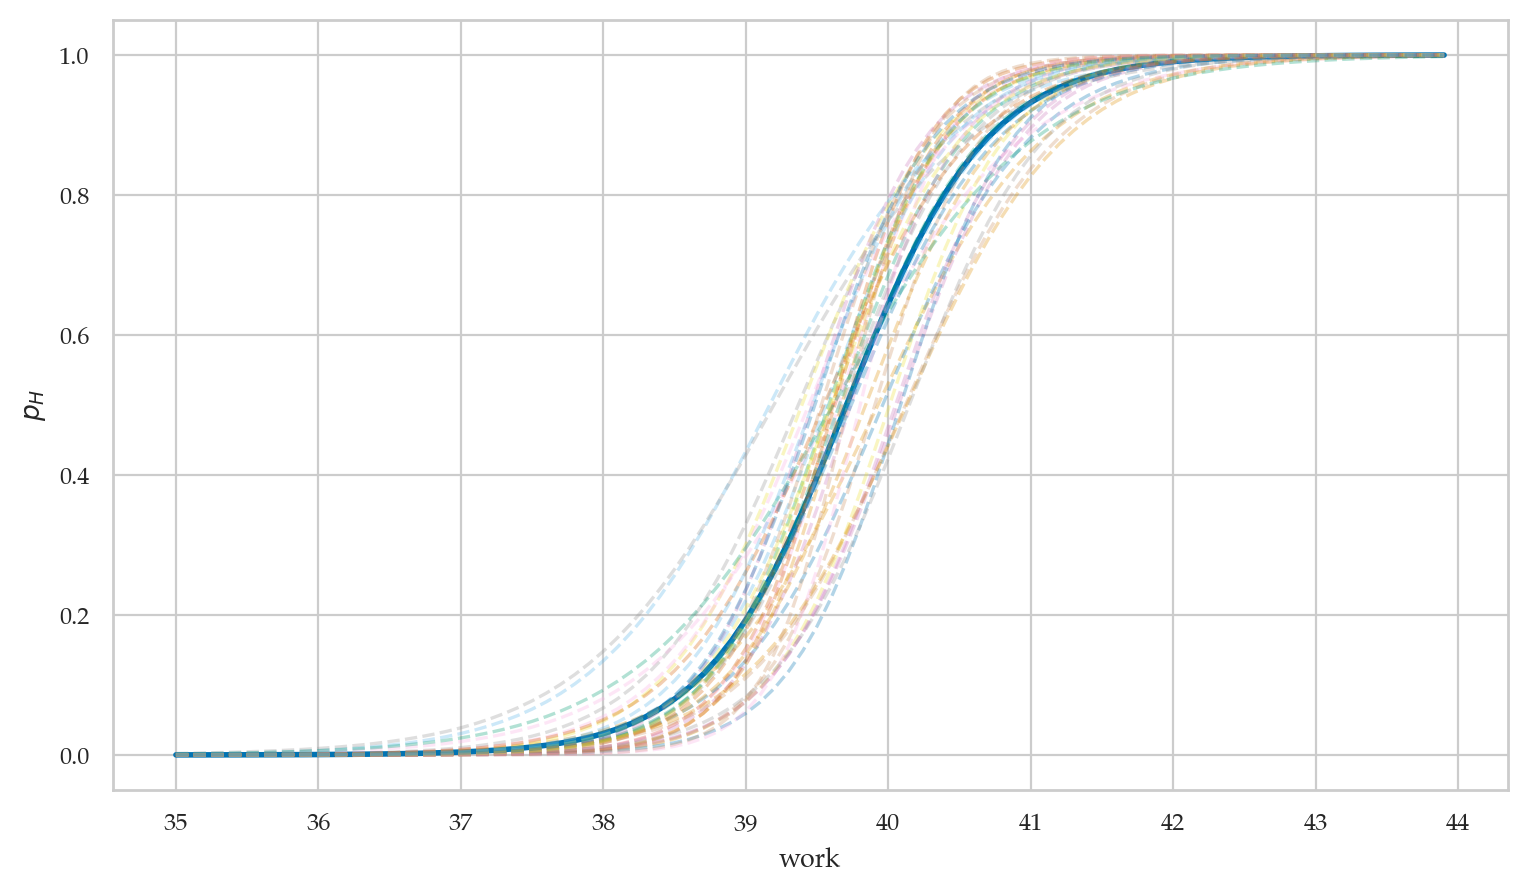

In [42]:
from scipy.special import expit

# generate predictions
works = np.arange(35, 44, 0.1)
new_interns = pd.DataFrame({"work": works})
idata3_pred = mod3.predict(idata3, data=new_interns, inplace=False)

# plot best-fit curve based on MAP estimates
intercepts = idata3["posterior"]['Intercept'].values
wslopes = idata3["posterior"]['work'].values
B0_MAP = az.plots.plot_utils.calculate_point_estimate('mode', intercepts)
Bw_MAP = az.plots.plot_utils.calculate_point_estimate('mode', wslopes)
print("MAP estimates:", B0_MAP.round(1), Bw_MAP.round(2))
p_MAP = expit(B0_MAP + Bw_MAP*works)
ax = sns.lineplot(x=works, y=p_MAP, lw=2)

# plot 40 samples
subset = np.random.choice(1000, 10, replace=False)
post3 = idata3_pred["posterior"]
post3_subset = post3.sel(draw=subset)
for ps in az.extract(post3_subset, var_names="p").T:
    sns.lineplot(x=works, y=ps, alpha=0.3, ax=ax, ls="--")
ax.set_xlabel("work")
ax.set_ylabel("$p_H$")
ax.set_xticks(range(35,44+1));

### Interpretation of the parameters

We can interpret the results on the *log-odds* scale,
the *odds* scale,
or as *marginal effects* (slopes) at particular values of the predictor $w$.

#### Parameters as changes in the log-odds

The mode of the posterior distribution $\widehat{B_w}_{\text{MAP}}$
corresponds to the change in log-odds per unit increase in work hours.

In [43]:
from ministats import mode_from_samples

post_work = idata3["posterior"]["work"].values.flatten()
mode_from_samples(post_work)

2.0291924050685317

#### Parameters as ratios of odds

We can also \tt{exp}-transform this estimate to obtain
the rate of increase in the odds of getting hired per additional hour of work invested.

In [44]:
np.exp(2.01)

7.463317347319193

Actually,
the more accurate way to summarize the odds ratio
would be to `exp`-transform the whole posterior distribution $f_{B_w|\tt{interns}}$,
then find the maximum using `mode_from_samples(np.exp(post_work))`,
which produces the estimate $6.81$.

#### Differences in probabilities

What is the *marginal effect* of the predictor `work`
for an intern who invests 40 hours of effort?

In [45]:
bmb.interpret.slopes(mod3, idata3, wrt={"work":[40]}, average_by=True)

,term,estimate_type,estimate,lower_3.0%,upper_97.0%
0,work,dydx,0.471178,0.271939,0.711613


In [46]:
# ALT. manual calculation based on derivative of `expit`
# sample the parameter p from `mod3` when work=40
work40 = pd.DataFrame({"work": [40]})
preds = mod3.predict(idata3, data=work40, inplace=False)
ps40 = preds["posterior"]["p"].values.flatten()
# use the slope formula dp/dwork = p*(1-p)*beta_work
marg_effect_at_40 = ps40 * (1 - ps40) * post_work
marg_effect_at_40.mean()

0.4711935788438129

### Predictions

Let's use the logistic regression model `mod3`
to predict the probability of being hired
for an intern that invests 42 hours of work per week.


In [47]:
work42 = pd.DataFrame({"work": [42]})
preds42 = mod3.predict(idata3, data=work42, inplace=False)
az.summary(preds42, var_names="p", kind="stats")

,mean,sd,hdi_3%,hdi_97%
p[0],0.988,0.016,0.961,1.0


The mean model prediction is $p(42) = 0.987 = 98.7\%$,
with $\mathbf{hdi}_{p,0.94} = [0.959, 1.0]$,
which means the intern will very likely get hired.

In [48]:
# ALT. compute using Bambi helper function
bmb.interpret.predictions(mod3, idata3, conditional={"work":42})

,work,estimate,lower_3.0%,upper_97.0%
0,42.0,0.987683,0.961228,0.999991


#### Plot predictions

We can visualize the predictions by plotting a histogram.

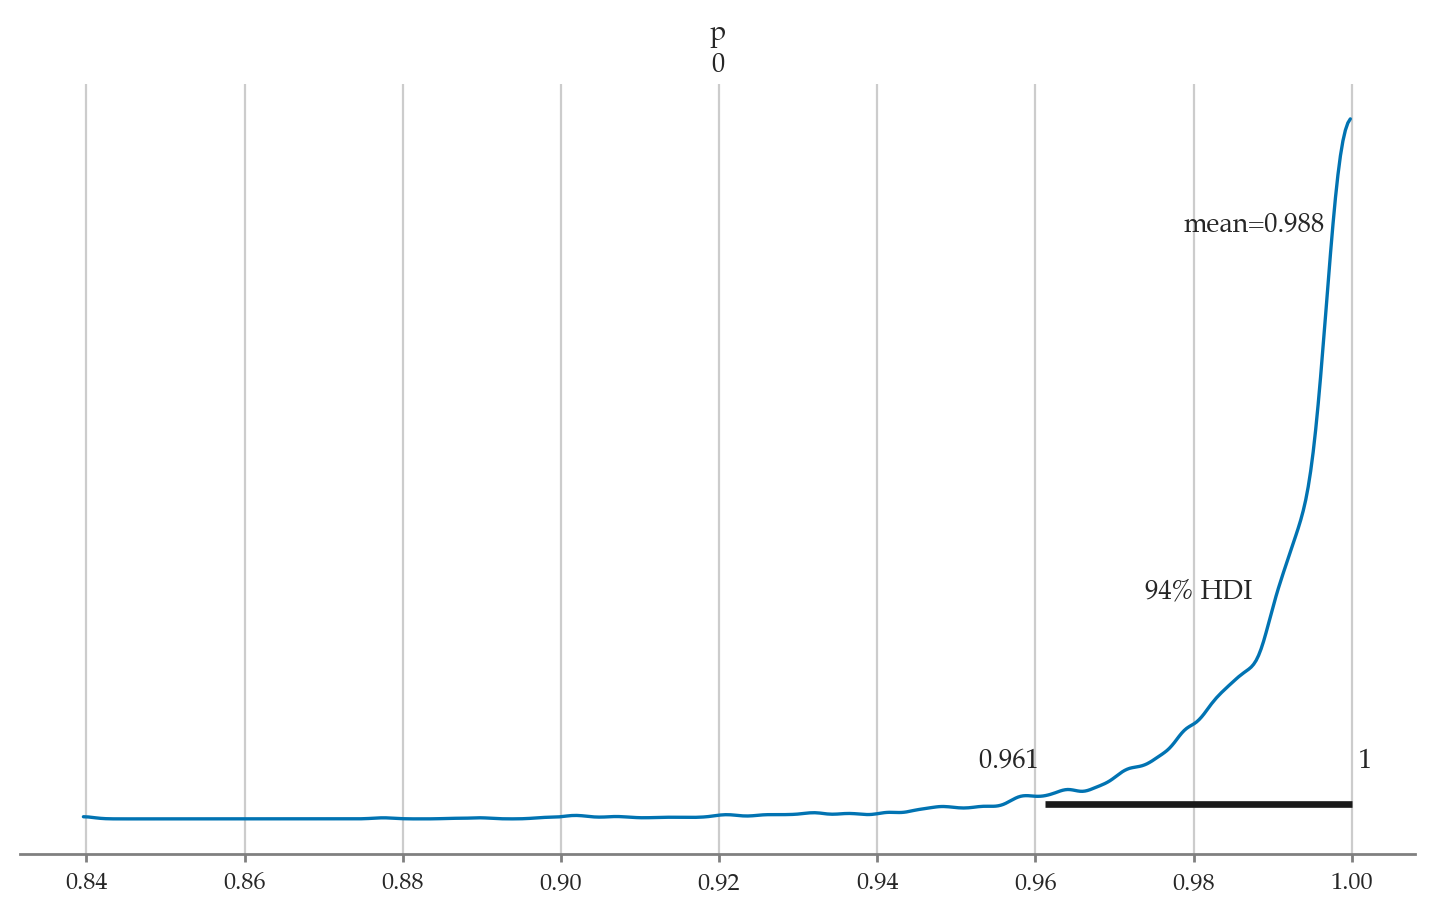

In [49]:
az.plot_posterior(preds42, var_names="p", round_to=3);

### Comparing to frequentist results

For your convenience,
I'll reproduce the `statsmodels` analysis from Section 4.6.

In [50]:
import statsmodels.formula.api as smf
lr1 = smf.logit("hired ~ 1 + work", data=interns).fit()
lr1.params

Optimization terminated successfully.
         Current function value: 0.138101
         Iterations 10


Intercept   -78.693205
work          1.981458
dtype: float64

In [51]:
lr1.conf_int(alpha=0.06)

,0,1
Intercept,-116.028234,-41.358176
work,1.040205,2.922711


### Conclusions

We end up with similar results...

## Explanations

### Robust linear regression

We swap out the Normal distribution for Student's $t$-distribution to handle outliers better
very useful when data has outliers; see EXX

Links:
 - https://bambinos.github.io/bambi/notebooks/t_regression.html
 - https://www.pymc.io/examples/generalized_linear_models/GLM-robust.html

In [52]:
#######################################################
priors1r = {
    "Intercept": bmb.Prior("Normal", mu=70, sigma=20),
    "effort": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("HalfStudentT", nu=4, sigma=10),
    "nu": bmb.Prior("Gamma", alpha=2, beta=0.1),
}

mod1r = bmb.Model("score ~ 1 + effort",
                 family="t",
                 link="identity",
                 priors=priors1r,
                 data=students)
mod1r

       Formula: score ~ 1 + effort
        Family: t
          Link: mu = identity
  Observations: 15
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 70.0, sigma: 20.0)
            effort ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 10.0)
            nu ~ Gamma(alpha: 2.0, beta: 0.1)

In [53]:
idata1r = mod1r.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, nu, Intercept, effort]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [54]:
az.summary(idata1r, kind="stats")

,mean,sd,hdi_3%,hdi_97%
sigma,4.881,1.199,2.889,7.088
nu,19.512,13.995,1.755,45.691
Intercept,34.056,6.697,21.465,46.680
effort,4.302,0.751,2.907,5.731


The mean of the slope $4.303$ is slightly less than the mean slope we found in `mod1` ($4.497$),
which shows the robust model doesn't care as much about the one outlier.

We also found a slightly smaller `sigma`, since we're using the $t$-distribution.

### Shrinkage priors

Shrinkage priors = Prior distributions for a parameter that shrink its posterior estimate towards a particular value.
Sparsity = A situation where most parameter values are zero and only a few are non-zero.

- Laplace priors L1 regularization = lasso regression https://en.wikipedia.org/wiki/Lasso_(statistics)
- Gaussian priors L2 regularization = ridge regression https://en.wikipedia.org/wiki/Ridge_regression
- Reference priors Reference prior ppal pha, beta, sigmaq91{sigma Produces the same results as frequentist linear regression
- Spike-and-slab priors Specialized for spike-and-slab prior = mix- ture of two distributions: one peaked around zero (spike) and the other a diffuse distribution (slab. The spike component identifies the zero elements whereas the slab component captures the non-zero coefficients.

### Standardizing predictors

We make choosing priors easier makes inference more efficient cf. 04_lm/cut_material/standardized_predictors.tex
Robust linear regression

## Discussion

### Comparison to frequentist linear models

- We can obtain similar results
- Bayesian models naturally apply regularization (no need to manually add in)

### Causal graphs

Causal graphs also used with Bayesian LMs (remember Sec 4.5)


### Next steps

- LMs work with categorical predators too, which is what we'll discuss in Section 5.4
- LMs can be extended hierarchical models, which is what we'll discuss in Section 5.5

## Exercises

### Exercise 1: redo some of the exercises/problems from Ch4 using Bayesian methods
### Exercise 2: redo examples of causal inference
### Exercise 3: fit model with different priors
### Exercise 4: redo logistic regression exercises from Sec 4.6

### Exercise 5: bioassay logistic regression

Gelman et al. (2003) present an example of an acute toxicity test, commonly performed on animals to estimate the toxicity of various compounds.

In this dataset `log_dose` includes 4 levels of dosage, on the log scale, each administered to 5 rats during the experiment. The response variable is death, the number of positive responses to the dosage.

The number of deaths can be modeled as a binomial response, with the probability of death being a linear function of dose:

$$\begin{aligned}
y_i &\sim \text{Binom}(n_i, p_i) \\
\text{logit}(p_i) &= a + b x_i
\end{aligned}$$

The common statistic of interest in such experiments is the LD50, the dosage at which the probability of death is 50%.


via https://github.com/fonnesbeck/pymc_sdss_2024/blob/main/notebooks/Section2-PyMC_Intro.ipynb





In [55]:
# Sample size in each group
n = 5

# Log dose in each group
log_dose = [-.86, -.3, -.05, .73]

# Outcomes
deaths = [0, 1, 3, 5]

df_bio = pd.DataFrame({"log_dose":log_dose, "deaths":deaths, "n":n})

In [56]:
# SOLUTION
priors_bio = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "log_dose": bmb.Prior("Normal", mu=0, sigma=5),
}

mod_bio = bmb.Model(formula="p(deaths,n) ~ 1 + log_dose",
                    family="binomial",
                    link="logit",
                    priors=priors_bio,
                    data=df_bio)

idata_bio = mod_bio.fit()

post_bio = idata_bio["posterior"]
post_bio["LD50"] = -post_bio["Intercept"] / post_bio["log_dose"]

az.summary(idata_bio)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, log_dose]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.592,0.809,-0.834,2.180,0.018,0.014,2140.0,2250.0,1.0
log_dose,6.461,2.588,1.832,11.156,0.058,0.051,2270.0,2018.0,1.0
LD50,-0.079,0.138,-0.308,0.200,0.003,0.003,2254.0,2698.0,1.0


### Exercise 6: redo Poisson regression exercises from Sec 4.6
### Exercise 7: fit normal and robust to the dataset ??TODO?? which has outliers


### Exercise 8: PhD delays

cf. https://www.rensvandeschoot.com/tutorials/advanced-bayesian-regression-in-jasp/  
https://zenodo.org/records/3999424  
https://sci-hub.se/https://www.nature.com/articles/ s43586-020-00001-2

## Links

# BONUS MATERIAL

### Simple linear regression using PyMC

(used in Chapter 4 conclusion)

In [57]:
# Linear regression model in PyMC
students = pd.read_csv("datasets/students.csv")

import pymc as pm
with pm.Model() as model:
    # Define the priors
    B0 = pm.Normal("B0", mu=30, sigma=20)
    Be = pm.Normal("Be", mu=0, sigma=10)
    Sigma = pm.HalfStudentT("Sigma", nu=4, sigma=10)
    
    # Define the data model
    M = B0 + Be * students["effort"]
    S = pm.Normal("S", mu=M, sigma=Sigma, observed=students["score"])
    
    # Fit the model
    idata = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [B0, Be, Sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [58]:
import arviz as az
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
B0,32.435,6.568,19.841,44.795
Be,4.504,0.726,3.173,5.954
Sigma,5.371,1.172,3.374,7.477


In [59]:
# cf. with Bambi results for the same model
az.summary(idata1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
sigma,5.356,1.167,3.501,7.617
Intercept,32.549,6.962,18.903,45.336
effort,4.489,0.765,3.102,5.992


## Simple linear regression on synthetic data

In [60]:
# Simulated data
np.random.seed(42)
x = np.random.normal(0, 1, 100)
y = 3 + 2 * x + np.random.normal(0, 1, 100)

In [61]:
df1 = pd.DataFrame({"x":x, "y":y})

priors1 = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=10),
    "x": bmb.Prior("Normal", mu=0, sigma=10),
    "sigma": bmb.Prior("HalfNormal", sigma=1),
}

model1 = bmb.Model("y ~ 1 + x",
                   priors=priors1,
                   data=df1)
print(model1)

idata = model1.fit(random_seed=42)

Initializing NUTS using jitter+adapt_diag...


       Formula: y ~ 1 + x
        Family: gaussian
          Link: mu = identity
  Observations: 100
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10.0)
            x ~ Normal(mu: 0.0, sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 1.0)


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, x]


Output()

/Users/ivan/Projects/Minireference/STATSbook/noBSstats/venv/lib/python3.12/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 0 seconds.


Sampling: [Intercept, sigma, x]


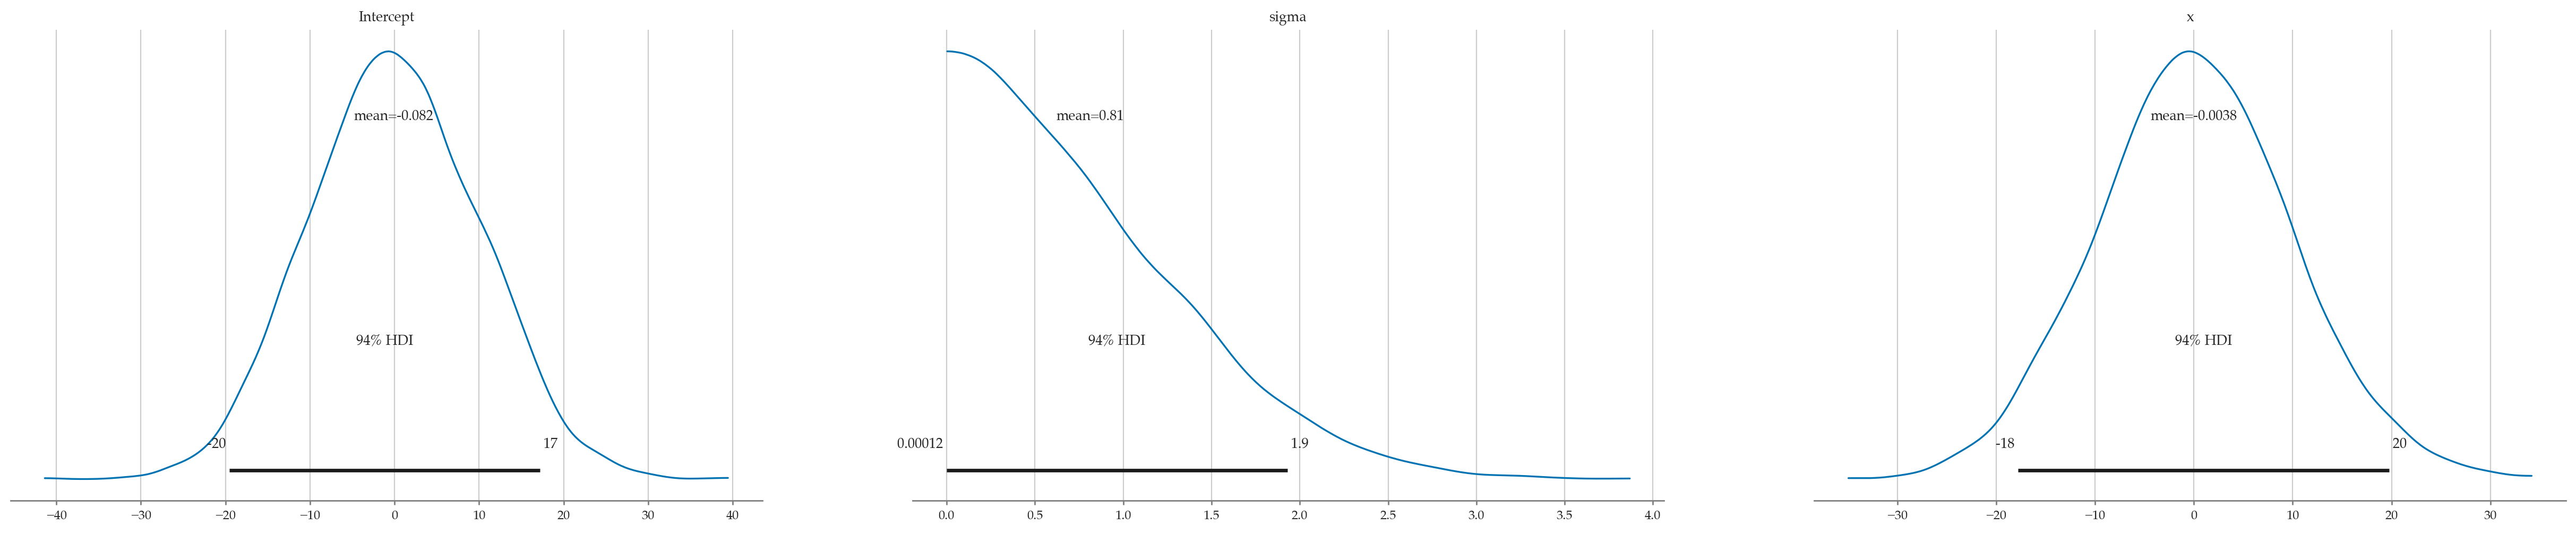

In [62]:
model1.plot_priors();

### Summary using mean


In [63]:
# Posterior Summary
summary = az.summary(idata, kind="stats")
summary

,mean,sd,hdi_3%,hdi_97%
sigma,0.959,0.070,0.830,1.087
Intercept,3.008,0.095,2.836,3.193
x,1.857,0.109,1.663,2.077


### Summary using median as focus statistic

ETI = Equal-Tailed Interval

In [64]:
az.summary(idata, stat_focus="median", kind="stats")

,median,mad,eti_3%,eti_97%
sigma,0.953,0.046,0.843,1.106
Intercept,3.009,0.065,2.827,3.187
x,1.856,0.071,1.648,2.063


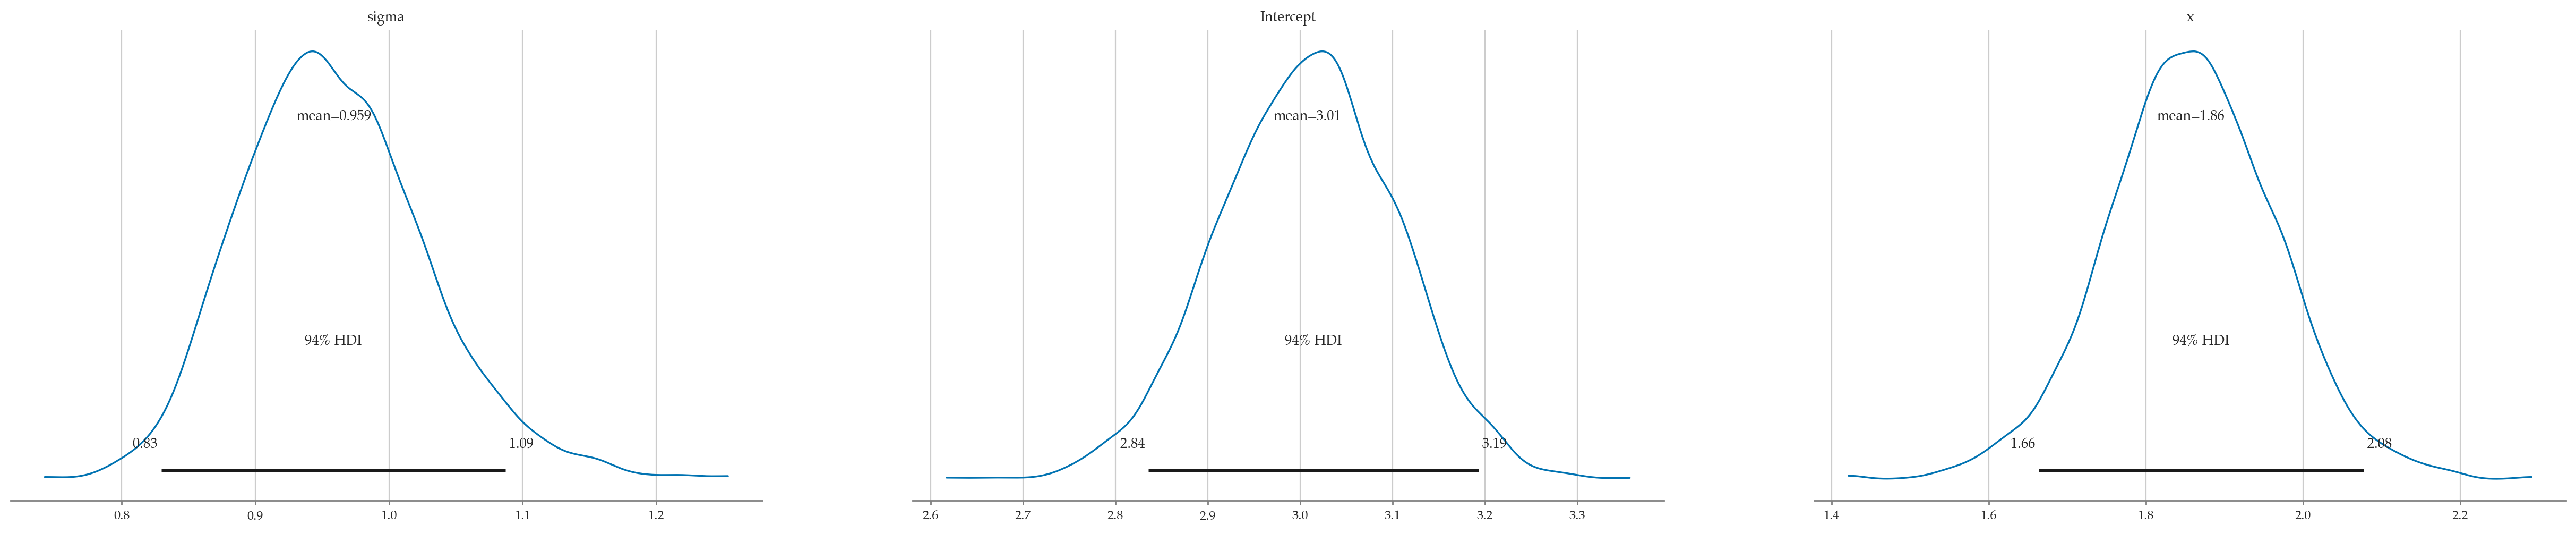

In [65]:
# Plotting posterior
az.plot_posterior(idata, point_estimate="mean", round_to=3);

Investigare further

https://python.arviz.org/en/latest/api/generated/arviz.plot_lm.html

In [66]:
# az.plot_lm(idata)

## Bonus Bayesian logistic regression example

via [file:///Users/ivan/Downloads/talks-main/pydataglobal21/index.html#15](/Users/ivan/Downloads/talks-main/pydataglobal21/index.html#15)

via https://github.com/tomicapretto/talks/blob/main/pydataglobal21/index.Rmd#L123

In [67]:
import bambi as bmb
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [68]:
model = bmb.Model("vote[clinton] ~ 0 + party_id + party_id:age", data, family="bernoulli")
print(model)
idata = model.fit(random_seed=42)

Modeling the probability that vote==clinton
Initializing NUTS using jitter+adapt_diag...


       Formula: vote[clinton] ~ 0 + party_id + party_id:age
        Family: bernoulli
          Link: p = logit
  Observations: 421
        Priors: 
    target = p
        Common-level effects
            party_id ~ Normal(mu: [0. 0. 0.], sigma: [1. 1. 1.])
            party_id:age ~ Normal(mu: [0. 0. 0.], sigma: [0.0586 0.0586 0.0586])


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [party_id, party_id:age]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


In [69]:
import pandas as pd
new_subjects = pd.DataFrame({"age": [20, 60], "party_id": ["independent"] * 2})
model.predict(idata, data=new_subjects)

# TODO: try to repdouce 
# https://github.com/tomicapretto/talks/blob/main/pydataglobal21/index.Rmd#L181-L193

### One more example 

via http://www.medicine.mcgill.ca/epidemiology/joseph/courses/EPIB-682/bayesreg.pdf

Fit a logistic regression model of bone fractures with independent variables `age` and `sex`.

The true model had: $\beta_0 = -25$, $\beta_{\tt{sex}} = 0.5$, $\beta_{\tt{age}} = 0.4$.

With so few data points and three parameters to estimate, do not expect posterior means/medians to equal the correct values exactly, but all would most likely be in the 95% intervals.

In [70]:
dfmed = pd.DataFrame(
    dict(sex=[1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1],
         age=[69, 57, 61, 60, 69, 74, 63, 68, 64, 53, 60, 58, 79, 56, 53, 74, 56, 76, 72, 56, 66, 52, 77, 70, 69, 76, 72, 53, 69, 59, 73, 77, 55, 77, 68, 62, 56, 68, 70, 60, 65, 55, 64, 75, 60, 67, 61, 69, 75, 68, 72, 71, 54, 52, 54, 50, 75, 59, 65, 60, 60, 57, 51, 51, 63, 57, 80, 52, 65, 72, 80, 73, 76, 79, 66, 51, 76, 75, 66, 75, 78, 70, 67, 51, 70, 71, 71, 74, 74, 60, 58, 55, 61, 65, 52, 68, 75, 52, 53, 70],
         frac=[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
1, 0, 1, 1, 0, 0, 1, 0, 0, 1])
)
# df3

In [71]:
priorsmed = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=1e4),
    "sex": bmb.Prior("Normal", mu=0, sigma=1e4),
    "age": bmb.Prior("Normal", mu=0, sigma=1e4),
}

modmed = bmb.Model("frac ~ 1 + sex + age",
                 family="bernoulli",
                 link="logit",
                 priors=priorsmed,
                 data=dfmed)
modmed

       Formula: frac ~ 1 + sex + age
        Family: bernoulli
          Link: p = logit
  Observations: 100
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 10000.0)
            sex ~ Normal(mu: 0.0, sigma: 10000.0)
            age ~ Normal(mu: 0.0, sigma: 10000.0)

In [72]:
idatamed = modmed.fit(draws=2000, random_seed=42)
az.summary(idatamed, kind="stats")

Modeling the probability that frac==1
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sex, age]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%
Intercept,-23.736,4.784,-32.936,-15.439
sex,1.476,0.765,0.091,2.966
age,0.374,0.074,0.244,0.516


In [73]:
import statsmodels.formula.api as smf
lrmed = smf.logit("frac ~ 1 + sex + age", data=dfmed).fit()
lrmed.params

Optimization terminated successfully.
         Current function value: 0.297593
         Iterations 8


Intercept   -21.850408
sex           1.361099
age           0.344670
dtype: float64